# Cell 1: Import Libraries

In [ ]:
%run 'NAS_Reinforcement_Learning_CIFAR10_Params.ipynb'

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import random_split

import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline


# Cell 2: Data Loading and Preprocessing

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # CIFAR-10 mean
                         (0.2023, 0.1994, 0.2010))  # CIFAR-10 std
])

# Load CIFAR-10 dataset
full_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)

# Reduce dataset size to simulate limited data
small_dataset_size = 5000  # Use only 5,000 samples
indices = list(range(len(full_dataset)))
random.shuffle(indices)
small_indices = indices[:small_dataset_size]
small_dataset = torch.utils.data.Subset(full_dataset, small_indices)


train_size = int(0.8 * len(small_dataset))
val_size = len(small_dataset) - train_size
train_subset, val_subset = random_split(small_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)


Files already downloaded and verified


# Cell 3: Define the Controller Model

In [3]:
class Controller(nn.Module):
    def __init__(self, hidden_size, num_layers, num_operations, num_filters):
        super(Controller, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_operations = num_operations
        self.num_filters = num_filters

        self.rnn = nn.LSTMCell(input_size=hidden_size, hidden_size=hidden_size)
        self.op_linear = nn.Linear(hidden_size, num_operations)
        self.filter_linear = nn.Linear(hidden_size, num_filters)
        self.num_embeddings = self.num_operations * self.num_filters
        print(f"Initializing embedding layer with num_embeddings = {self.num_embeddings}")
        self.embedding = nn.Embedding(self.num_embeddings, hidden_size)

    def forward(self, hidden, cell, inputs):
        hx, cx = self.rnn(inputs, (hidden, cell))
        op_logits = self.op_linear(hx)
        filter_logits = self.filter_linear(hx)
        return op_logits, filter_logits, hx, cx


# Cell 4: Define the Child Network Training Process

In [4]:

# Possible operations with varying output channels
OPERATIONS = [
    ('conv3x3', 16),
    ('conv3x3', 32),
    ('conv5x5', 16),
    ('conv5x5', 32),
    ('maxpool3x3', None)
]

def construct_network(architecture):
    layers = []
    input_channels = 3
    current_channels = input_channels
    max_num_layers = 3  # Limit the number of layers
    for idx, (op_idx, filter_size_idx) in enumerate(architecture):
        if idx >= max_num_layers:
            break
        op_name = OPERATIONS[op_idx]
        out_channels = FILTER_SIZES[filter_size_idx]
        if op_name == 'conv3x3':
            layers.append(nn.Conv2d(current_channels, out_channels, kernel_size=3, padding=1))
            current_channels = out_channels
        elif op_name == 'conv5x5':
            layers.append(nn.Conv2d(current_channels, out_channels, kernel_size=5, padding=2))
            current_channels = out_channels
        elif op_name == 'maxpool3x3':
            layers.append(nn.MaxPool2d(kernel_size=3, stride=1, padding=1))
            # current_channels remains the same
        layers.append(nn.ReLU())
    layers.append(nn.AdaptiveAvgPool2d(1))
    layers.append(nn.Flatten())
    layers.append(nn.Linear(current_channels, 10))
    return nn.Sequential(*layers)



def train_child_network(network, epochs=1):
    network.train()
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    max_batches = 10  # Limit to 10 batches per epoch
    for epoch in range(epochs):
        batch_count = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = network(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            batch_count += 1
            if batch_count >= max_batches:
                break  # Stop after processing max_batches



# Cell 5: Define the Reinforcement Learning Loop

In [5]:
def reinforce(controller, controller_optimizer, num_layers, num_operations, num_filters, num_samples):
    controller.train()
    all_rewards = []
    for sample in range(num_samples):
        hidden = torch.zeros(1, controller.hidden_size)
        cell = torch.zeros(1, controller.hidden_size)
        inputs = torch.zeros(1, controller.hidden_size)
        architecture = []
        log_probs = []
        for _ in range(num_layers):
            op_logits, filter_logits, hidden, cell = controller(hidden, cell, inputs)
            op_probs = F.softmax(op_logits, dim=-1)
            filter_probs = F.softmax(filter_logits, dim=-1)
            op_dist = torch.distributions.Categorical(op_probs)
            filter_dist = torch.distributions.Categorical(filter_probs)
            op = op_dist.sample().long()
            filter_size = filter_dist.sample().long()
            embedding_index = op * controller.num_filters + filter_size
            # Print statements for debugging
            #print(f"op: {op.item()}, filter_size: {filter_size.item()}")
            #print(f"embedding_index: {embedding_index.item()}, max index: {controller.num_operations * controller.num_filters - 1}")
            # Ensure embedding_index is within bounds
            if embedding_index.item() >= controller.num_operations * controller.num_filters:
                raise ValueError(f"embedding_index {embedding_index.item()} out of bounds")
            inputs = controller.embedding(embedding_index)
            architecture.append((op.item(), filter_size.item()))
            log_probs.append(op_dist.log_prob(op) + filter_dist.log_prob(filter_size))
        # ... rest of the code ...

        try:
            network = construct_network(architecture)
            train_child_network(network, epochs=1)
            # Evaluate on validation data
            network.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for data, target in val_loader:
                    output = network(data)
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()
            reward = correct / total
        except Exception as e:
            print(f"Exception occurred: {e}")
            reward = 0.0
        all_rewards.append(reward)
        # Policy gradient update
        loss = -sum(log_probs) * reward
        controller_optimizer.zero_grad()
        loss.backward()
        controller_optimizer.step()
    return all_rewards


# Cell 6: Train the Controller

Initializing embedding layer with num_embeddings = 9
Epoch 1/10, Average Reward: 0.1216, Time: 14.51s
Epoch 2/10, Average Reward: 0.1130, Time: 18.23s
Epoch 3/10, Average Reward: 0.1256, Time: 12.60s
Epoch 4/10, Average Reward: 0.1166, Time: 14.79s
Epoch 5/10, Average Reward: 0.1322, Time: 17.76s
Epoch 6/10, Average Reward: 0.1300, Time: 12.04s
Epoch 7/10, Average Reward: 0.1250, Time: 22.26s
Epoch 8/10, Average Reward: 0.1236, Time: 18.13s
Epoch 9/10, Average Reward: 0.1514, Time: 18.79s
Epoch 10/10, Average Reward: 0.1000, Time: 15.31s


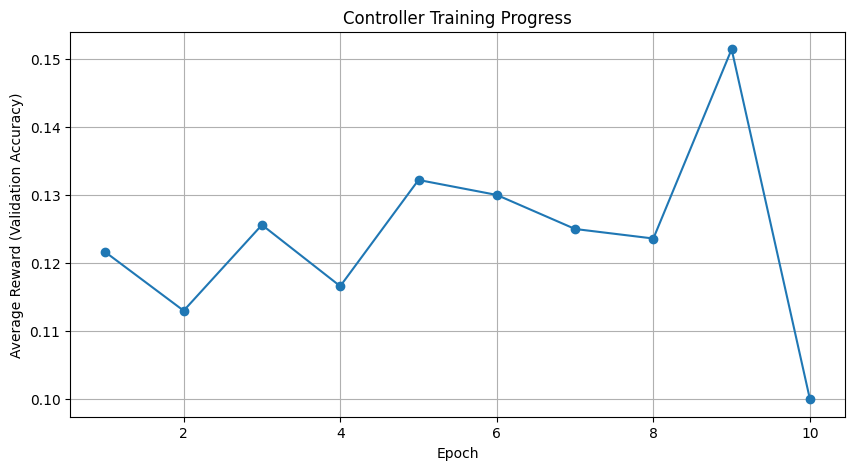

In [6]:
hidden_size = 35
num_layers = 5
OPERATIONS = ['conv3x3', 'conv5x5', 'maxpool3x3']
FILTER_SIZES = [16, 32, 64]
num_operations = len(OPERATIONS)
num_filters = len(FILTER_SIZES)
controller = Controller(hidden_size, num_layers, num_operations, num_filters)
controller_optimizer = optim.Adam(controller.parameters(), lr=0.001)


epochs = 10
rewards_per_epoch = []

for epoch in range(epochs):
    start_time = time.time()
    rewards = reinforce(controller, controller_optimizer, num_layers, num_operations, num_filters, num_samples=5)
    avg_reward = np.mean(rewards)
    rewards_per_epoch.append(avg_reward)
    print(f"Epoch {epoch+1}/{epochs}, Average Reward: {avg_reward:.4f}, Time: {time.time() - start_time:.2f}s")

# Plotting rewards
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), rewards_per_epoch, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Reward (Validation Accuracy)')
plt.title('Controller Training Progress')
plt.grid(True)
plt.show()


# Cell 7: Evaluate the Best Architecture

In [7]:


controller.eval()
hidden = torch.zeros(1, controller.hidden_size)
cell = torch.zeros(1, controller.hidden_size)
inputs = torch.zeros(1, controller.hidden_size)  # Corrected initialization
architecture = []
for _ in range(num_layers):
    op_logits, filter_logits, hidden, cell = controller(hidden, cell, inputs)
    op = torch.argmax(op_logits, dim=-1)
    filter_size = torch.argmax(filter_logits, dim=-1)
    architecture.append((op.item(), filter_size.item()))
    # Compute the embedding index
    embedding_index = op * controller.num_filters + filter_size
    inputs = controller.embedding(embedding_index)


print("Best Architecture:", [OPERATIONS[op] for op in architecture])

# Construct and train the best network
best_network = construct_network(architecture)
train_child_network(best_network, epochs=5)

# Evaluate on test data
best_network.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = best_network(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
test_accuracy = correct / total
print(f"Test Accuracy of Best Architecture: {test_accuracy:.4f}")


TypeError: list indices must be integers or slices, not tuple

# Cell 8: Visualize Results

In [ ]:


# Placeholder for visualization code, such as plotting rewards over epochs.
# In this simplified implementation, we only printed average rewards per epoch.

# For example, you might have collected rewards per epoch and can plot them:
rewards_per_epoch = []

epochs = 10
for epoch in range(epochs):
    start_time = time.time()
    rewards = reinforce(controller, controller_optimizer, num_layers, num_operations, num_samples=1)
    avg_reward = np.mean(rewards)
    rewards_per_epoch.append(avg_reward)
    print(f"Epoch {epoch+1}/{epochs}, Average Reward: {avg_reward:.4f}, Time: {time.time() - start_time:.2f}s")

# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), rewards_per_epoch, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Reward (Validation Accuracy)')
plt.title('Rewards over Epochs')
plt.grid(True)
plt.show()
